## Testing 3 different values of sparsity : 0.2 0.5 and 0.8 Power

In [2]:
import numpy as np
data_path1 = "/Users/waelbenslima/Desktop/data/phitwo1.txt"
data1 = np.loadtxt(data_path1)
data_reshaped1 = data1.reshape((1331, 171, 171))
data_path3 = "/Users/waelbenslima/Desktop/data/power1.txt"
data3 = np.loadtxt(data_path3)
data_reshaped3 = data3.reshape((1331, 171, 171))

## Sparsity 0.2

Training with sparsity = 0.2
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 619ms/step - loss: 0.0900 - val_loss: 0.0177
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 610ms/step - loss: 0.0151 - val_loss: 0.0099
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 598ms/step - loss: 0.0089 - val_loss: 0.0041
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 605ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 603ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 598ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 606ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 579ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 603ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 593ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 711ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 12/20


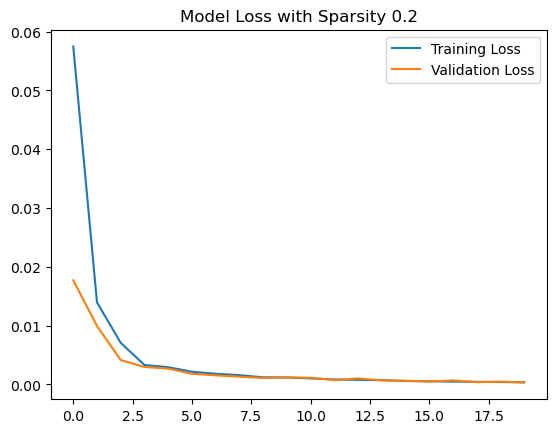

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from sklearn.model_selection import train_test_split

# Load data for power (assuming you have the power data in a variable like 'data_reshaped3')
power_norm = data_reshaped3 / np.max(data_reshaped3)  # Normalize power data
phi2_norm = data_reshaped1 / np.max(data_reshaped1)  # Normalize phi2 data

# Define function to generate random masks with different sparsity levels
def generate_random_mask(shape, sparsity):
    mask = np.random.choice([0, 1], size=shape, p=[sparsity, 1 - sparsity])
    return mask

# Set sparsity value
sparsity = 0.2
print(f"Training with sparsity = {sparsity}")

# Apply masks to phi2 data
masks = np.array([generate_random_mask(phi2_norm[0].shape, sparsity) for _ in range(len(phi2_norm))])
phi2_masked = phi2_norm * masks

# Split into training and testing sets
X_train, X_test, y_train, y_test, masks_train, masks_test = train_test_split(
    phi2_masked, power_norm, masks, test_size=0.2, random_state=42  # Using power_norm as target
)

# Define the CNN model for reconstruction of power from masked phi2
input_shape = (171, 171, 1)
mask_input_shape = (171, 171, 1)

phi2_input = layers.Input(shape=input_shape, name="phi2_input")
mask_input = layers.Input(shape=mask_input_shape, name="mask_input")

# Combine masked input
masked_phi2 = layers.Multiply()([phi2_input, mask_input])

# CNN model for reconstruction of power
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(masked_phi2)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
output = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Cropping to handle dimensional mismatch
output = layers.Cropping2D(cropping=((0, 1), (0, 1)))(output)

# Create the model
model = models.Model(inputs=[phi2_input, mask_input], outputs=output)
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(
    [X_train, masks_train], y_train,
    validation_data=([X_test, masks_test], y_test),
    epochs=20,
    batch_size=32
)

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title(f'Model Loss with Sparsity {sparsity}')
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


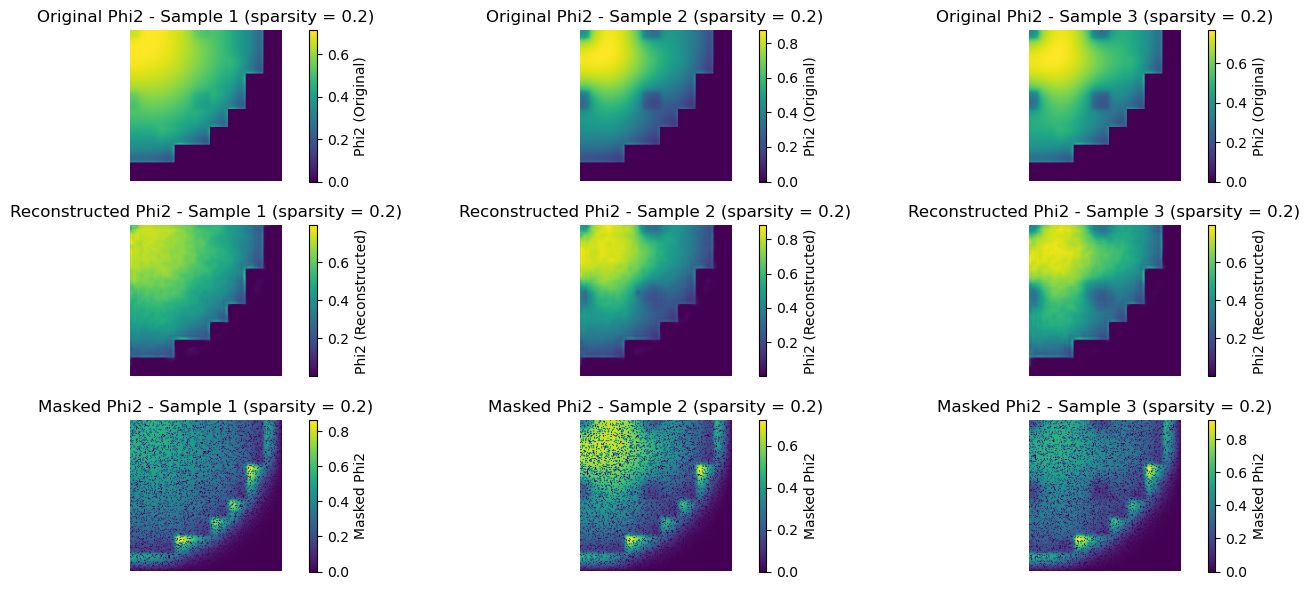

In [9]:
# Predict the output for the noisy input (sparsity = 0.2)
predicted_phi2_002 = model.predict([X_test, masks_test])

# Visualize results for sparsity = 0.2
n_samples = 3  # Number of samples to display
plt.figure(figsize=(15, 6))
for i in range(n_samples):
    # Original Phi2 (Ground truth)
    plt.subplot(3, n_samples, i + 1)
    plt.imshow(y_test[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Phi2 (Original)')
    plt.title(f'Original Phi2 - Sample {i+1} (sparsity = 0.2)')
    plt.axis('off')

    # Reconstructed Phi2 (Predicted)
    plt.subplot(3, n_samples, i + 1 + n_samples)
    plt.imshow(predicted_phi2_002[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Phi2 (Reconstructed)')
    plt.title(f'Reconstructed Phi2 - Sample {i+1} (sparsity = 0.2)')
    plt.axis('off')

    # Masked Phi2 (Input)
    plt.subplot(3, n_samples, i + 1 + 2 * n_samples)
    plt.imshow(X_test[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Masked Phi2')
    plt.title(f'Masked Phi2 - Sample {i+1} (sparsity = 0.2)')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [13]:
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Predict the output for the noisy input (sparsity = 0.2)
predicted_phi2_002 = model.predict([X_test, masks_test])

# Flatten the images for metric calculations
y_true_flat = y_test.flatten()  # True phi2 values
y_pred_flat = predicted_phi2_002.flatten()  # Predicted phi2 values

# 1. Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))

# 2. Calculate L∞ Error (Maximum absolute error)
l_inf_error = np.max(np.abs(y_true_flat - y_pred_flat))

# 3. Calculate SSIM (Structural Similarity Index)
ssim_index = ssim(y_test[0].reshape(171, 171), predicted_phi2_002[0].reshape(171, 171), data_range=1)

# 4. Calculate L2 Error
l2_error = np.linalg.norm(y_true_flat - y_pred_flat)

# 5. Calculate Relative L2 Error
true_l2_norm = np.linalg.norm(y_true_flat)
relative_l2_error = (l2_error / true_l2_norm) * 100  # Convert to percentage

# Print the results for sparsity = 0.2
print(f"Sparsity = 0.2:")
print(f"RMSE: {rmse}")
print(f"L∞ Error: {l_inf_error}")
print(f"SSIM: {ssim_index}")
print(f"L2 Error: {l2_error}")
print(f"Relative L2 Error: {relative_l2_error:.2f}%")
print("-" * 50)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step
Sparsity = 0.2:
RMSE: 0.018201034228185736
L∞ Error: 0.36122697591781616
SSIM: 0.9475133165760695
L2 Error: 50.856656823684546
Relative L2 Error: 4.38%
--------------------------------------------------


## Sparsity 0.5

Training with sparsity = 0.5
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 567ms/step - loss: 0.0862 - val_loss: 0.0187
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 565ms/step - loss: 0.0149 - val_loss: 0.0113
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 560ms/step - loss: 0.0074 - val_loss: 0.0058
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 563ms/step - loss: 0.0049 - val_loss: 0.0035
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 561ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 563ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 567ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 567ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 563ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 563ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 562ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 12/20


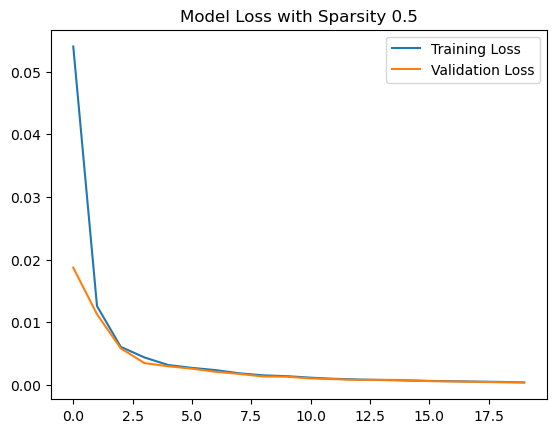

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from sklearn.model_selection import train_test_split

# Load data for power (assuming you have the power data in a variable like 'data_reshaped3')
power_norm = data_reshaped3 / np.max(data_reshaped3)  # Normalize power data
phi2_norm = data_reshaped1 / np.max(data_reshaped1)  # Normalize phi2 data

# Define function to generate random masks with different sparsity levels
def generate_random_mask(shape, sparsity):
    mask = np.random.choice([0, 1], size=shape, p=[sparsity, 1 - sparsity])
    return mask

# Set sparsity value
sparsity = 0.5
print(f"Training with sparsity = {sparsity}")

# Apply masks to phi2 data
masks = np.array([generate_random_mask(phi2_norm[0].shape, sparsity) for _ in range(len(phi2_norm))])
phi2_masked = phi2_norm * masks

# Split into training and testing sets
X_train, X_test, y_train, y_test, masks_train, masks_test = train_test_split(
    phi2_masked, power_norm, masks, test_size=0.2, random_state=42  # Using power_norm as target
)

# Define the CNN model for reconstruction of power from masked phi2
input_shape = (171, 171, 1)
mask_input_shape = (171, 171, 1)

phi2_input = layers.Input(shape=input_shape, name="phi2_input")
mask_input = layers.Input(shape=mask_input_shape, name="mask_input")

# Combine masked input
masked_phi2 = layers.Multiply()([phi2_input, mask_input])

# CNN model for reconstruction of power
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(masked_phi2)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
output = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Cropping to handle dimensional mismatch
output = layers.Cropping2D(cropping=((0, 1), (0, 1)))(output)

# Create the model
model = models.Model(inputs=[phi2_input, mask_input], outputs=output)
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(
    [X_train, masks_train], y_train,
    validation_data=([X_test, masks_test], y_test),
    epochs=20,
    batch_size=32
)

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title(f'Model Loss with Sparsity {sparsity}')
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


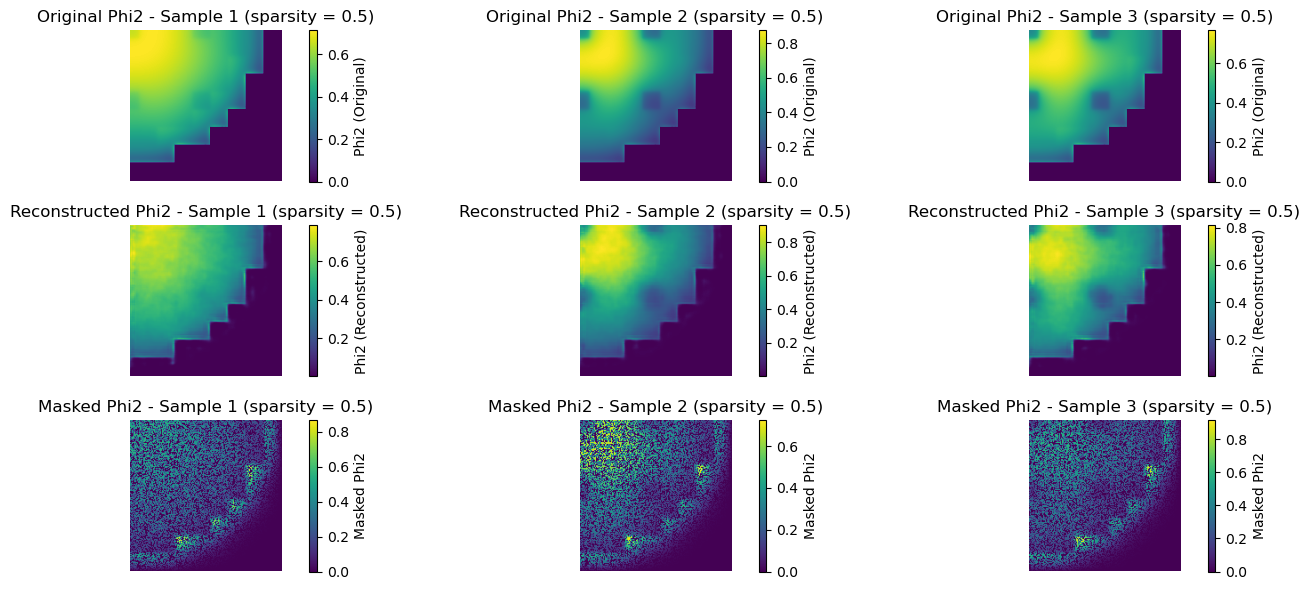

In [17]:
# Predict the output for the noisy input (sparsity = 0.5)
predicted_phi2_005 = model.predict([X_test, masks_test])

# Visualize results for sparsity = 0.5
n_samples = 3  # Number of samples to display
plt.figure(figsize=(15, 6))
for i in range(n_samples):
    # Original Phi2 (Ground truth)
    plt.subplot(3, n_samples, i + 1)
    plt.imshow(y_test[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Phi2 (Original)')
    plt.title(f'Original Phi2 - Sample {i+1} (sparsity = 0.5)')
    plt.axis('off')

    # Reconstructed Phi2 (Predicted)
    plt.subplot(3, n_samples, i + 1 + n_samples)
    plt.imshow(predicted_phi2_005[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Phi2 (Reconstructed)')
    plt.title(f'Reconstructed Phi2 - Sample {i+1} (sparsity = 0.5)')
    plt.axis('off')

    # Masked Phi2 (Input)
    plt.subplot(3, n_samples, i + 1 + 2 * n_samples)
    plt.imshow(X_test[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Masked Phi2')
    plt.title(f'Masked Phi2 - Sample {i+1} (sparsity = 0.5)')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [19]:
# Predict the output for the noisy input (sparsity = 0.5)
predicted_phi2_005 = model.predict([X_test, masks_test])

# Flatten the images for metric calculations
y_true_flat = y_test.flatten()  # True phi2 values
y_pred_flat = predicted_phi2_005.flatten()  # Predicted phi2 values

# 1. Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))

# 2. Calculate L∞ Error (Maximum absolute error)
l_inf_error = np.max(np.abs(y_true_flat - y_pred_flat))

# 3. Calculate SSIM (Structural Similarity Index)
ssim_index = ssim(y_test[0].reshape(171, 171), predicted_phi2_005[0].reshape(171, 171), data_range=1)

# 4. Calculate L2 Error
l2_error = np.linalg.norm(y_true_flat - y_pred_flat)

# 5. Calculate Relative L2 Error
true_l2_norm = np.linalg.norm(y_true_flat)
relative_l2_error = (l2_error / true_l2_norm) * 100  # Convert to percentage

# Print the results for sparsity = 0.5
print(f"Sparsity = 0.5:")
print(f"RMSE: {rmse}")
print(f"L∞ Error: {l_inf_error}")
print(f"SSIM: {ssim_index}")
print(f"L2 Error: {l2_error}")
print(f"Relative L2 Error: {relative_l2_error:.2f}%")
print("-" * 50)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step
Sparsity = 0.5:
RMSE: 0.019177026080923944
L∞ Error: 0.4460047483444214
SSIM: 0.928940638524046
L2 Error: 53.58373716950745
Relative L2 Error: 4.62%
--------------------------------------------------


## Sparsity 0.8

Training with sparsity = 0.8
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 634ms/step - loss: 0.0892 - val_loss: 0.0229
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 683ms/step - loss: 0.0198 - val_loss: 0.0149
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 608ms/step - loss: 0.0140 - val_loss: 0.0099
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 604ms/step - loss: 0.0100 - val_loss: 0.0068
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 579ms/step - loss: 0.0062 - val_loss: 0.0065
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 583ms/step - loss: 0.0049 - val_loss: 0.0036
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 580ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 568ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 615ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 635ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 586ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 12/20


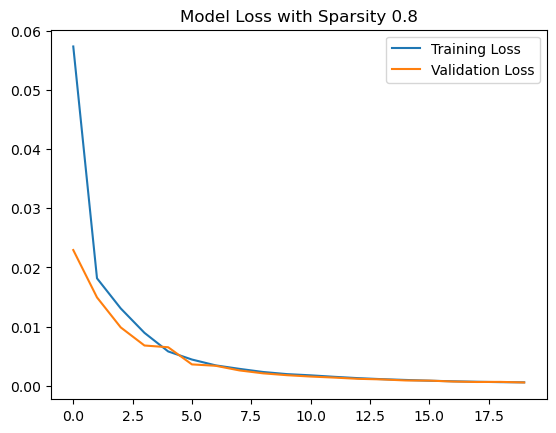

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from sklearn.model_selection import train_test_split

# Load data for power (assuming you have the power data in a variable like 'data_reshaped3')
power_norm = data_reshaped3 / np.max(data_reshaped3)  # Normalize power data
phi2_norm = data_reshaped1 / np.max(data_reshaped1)  # Normalize phi2 data

# Define function to generate random masks with different sparsity levels
def generate_random_mask(shape, sparsity):
    mask = np.random.choice([0, 1], size=shape, p=[sparsity, 1 - sparsity])
    return mask

# Set sparsity value
sparsity = 0.8
print(f"Training with sparsity = {sparsity}")

# Apply masks to phi2 data
masks = np.array([generate_random_mask(phi2_norm[0].shape, sparsity) for _ in range(len(phi2_norm))])
phi2_masked = phi2_norm * masks

# Split into training and testing sets
X_train, X_test, y_train, y_test, masks_train, masks_test = train_test_split(
    phi2_masked, power_norm, masks, test_size=0.2, random_state=42  # Using power_norm as target
)

# Define the CNN model for reconstruction of power from masked phi2
input_shape = (171, 171, 1)
mask_input_shape = (171, 171, 1)

phi2_input = layers.Input(shape=input_shape, name="phi2_input")
mask_input = layers.Input(shape=mask_input_shape, name="mask_input")

# Combine masked input
masked_phi2 = layers.Multiply()([phi2_input, mask_input])

# CNN model for reconstruction of power
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(masked_phi2)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
output = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Cropping to handle dimensional mismatch
output = layers.Cropping2D(cropping=((0, 1), (0, 1)))(output)

# Create the model
model = models.Model(inputs=[phi2_input, mask_input], outputs=output)
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(
    [X_train, masks_train], y_train,
    validation_data=([X_test, masks_test], y_test),
    epochs=20,
    batch_size=32
)

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title(f'Model Loss with Sparsity {sparsity}')
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


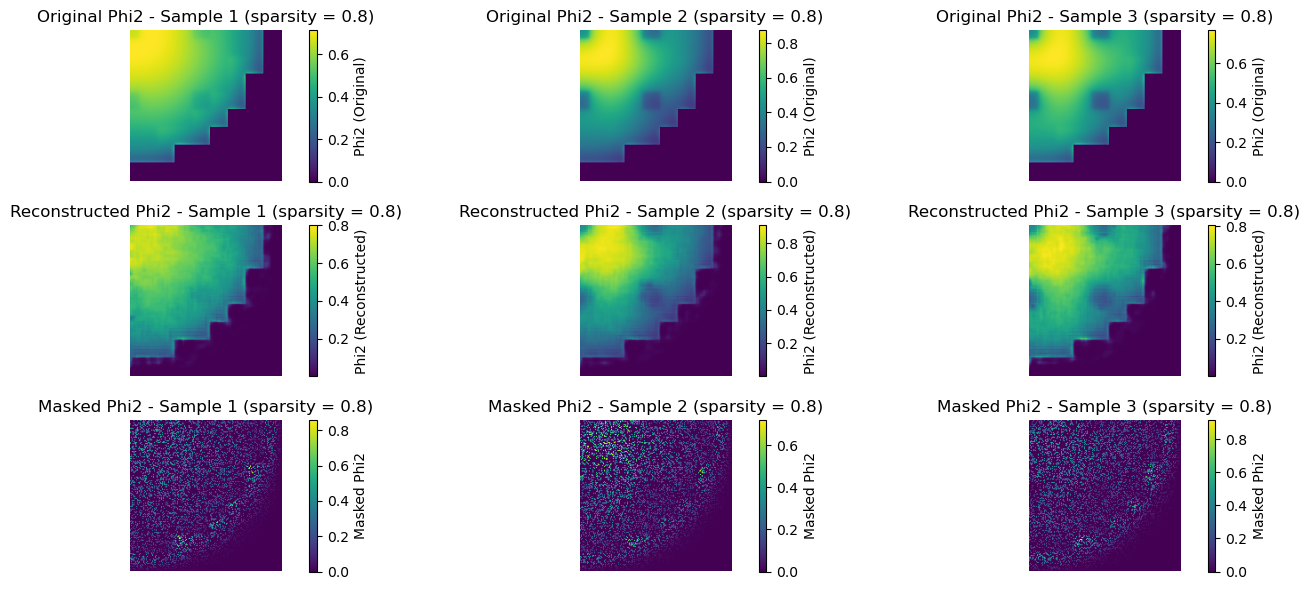

In [23]:
# Predict the output for the noisy input (sparsity = 0.8)
predicted_phi2_008 = model.predict([X_test, masks_test])

# Visualize results for sparsity = 0.8
n_samples = 3  # Number of samples to display
plt.figure(figsize=(15, 6))
for i in range(n_samples):
    # Original Phi2 (Ground truth)
    plt.subplot(3, n_samples, i + 1)
    plt.imshow(y_test[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Phi2 (Original)')
    plt.title(f'Original Phi2 - Sample {i+1} (sparsity = 0.8)')
    plt.axis('off')

    # Reconstructed Phi2 (Predicted)
    plt.subplot(3, n_samples, i + 1 + n_samples)
    plt.imshow(predicted_phi2_008[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Phi2 (Reconstructed)')
    plt.title(f'Reconstructed Phi2 - Sample {i+1} (sparsity = 0.8)')
    plt.axis('off')

    # Masked Phi2 (Input)
    plt.subplot(3, n_samples, i + 1 + 2 * n_samples)
    plt.imshow(X_test[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Masked Phi2')
    plt.title(f'Masked Phi2 - Sample {i+1} (sparsity = 0.8)')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [25]:
# Predict the output for the noisy input (sparsity = 0.8)
predicted_phi2_008 = model.predict([X_test, masks_test])

# Flatten the images for metric calculations
y_true_flat = y_test.flatten()  # True phi2 values
y_pred_flat = predicted_phi2_008.flatten()  # Predicted phi2 values

# 1. Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))

# 2. Calculate L∞ Error (Maximum absolute error)
l_inf_error = np.max(np.abs(y_true_flat - y_pred_flat))

# 3. Calculate SSIM (Structural Similarity Index)
ssim_index = ssim(y_test[0].reshape(171, 171), predicted_phi2_008[0].reshape(171, 171), data_range=1)

# 4. Calculate L2 Error
l2_error = np.linalg.norm(y_true_flat - y_pred_flat)

# 5. Calculate Relative L2 Error
true_l2_norm = np.linalg.norm(y_true_flat)
relative_l2_error = (l2_error / true_l2_norm) * 100  # Convert to percentage

# Print the results for sparsity = 0.8
print(f"Sparsity = 0.8:")
print(f"RMSE: {rmse}")
print(f"L∞ Error: {l_inf_error}")
print(f"SSIM: {ssim_index}")
print(f"L2 Error: {l2_error}")
print(f"Relative L2 Error: {relative_l2_error:.2f}%")
print("-" * 50)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step
Sparsity = 0.8:
RMSE: 0.023339681270924357
L∞ Error: 0.6360628482388573
SSIM: 0.882203025506059
L2 Error: 65.21487437958345
Relative L2 Error: 5.62%
--------------------------------------------------
